<h1>Finding a place to live</h1>
<h2><i>-The Power of Analytics</i></h2>
by Joachim Eriksson, 17.02.2021

<h1>Data Gathering</h1>
In this part I will web scrape boroughs from Wikipedia, append coordinates using GeoPy, and get venues from Foursquare. 

In [83]:
import pandas as pd 

<h2>Getting the boroughs in Oslo</h2>

In [84]:
url = "https://no.wikipedia.org/wiki/Liste_over_Oslos_bydeler" # list over Oslo's boroughs
df = pd.read_html(url, match="Bydel")[0] #matching on bourough to find appropriate table and selecting first match
df.columns = ["Borough", "Population", "Square KM", "Borough ID"]
df

,Borough,Population,Square KM,Borough ID
0,Alna,49 801,137,12
1,Bjerke,33 422,77,9
2,Frogner,59 269,83,5
3,Gamle Oslo,58 671,75,1
4,Grorud,27 707,82,10
5,Grünerløkka,62 423,48,2
6,Nordre Aker,52 327,136,8
7,Nordstrand,52 459,169,14
8,Sagene,45 089,31,3
9,St. Hanshaugen,38 945,36,4


<h2>Appending coordinates to the boroughs</h2>

In [85]:
import requests #used for API calls
import time #used for sleep
import json
#!pip install geopy
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import numpy as np

In [86]:
#use geocoding to get longitude and latitude for the Boroughs
results = []

for borough in df["Borough"]:
    geolocator = Nominatim(user_agent="user")
    location = geolocator.geocode(f"{borough}, Oslo")

    #generate a dictionary per borough with lat and long values
    data = {
        "Borough": borough,
        "lat": location.latitude,
        "lng": location.longitude
    }

    #append each iteration into the results list
    results.append(data)

#create a json file 
with open("geocoding.json", "w") as f:
    json.dump(results, f, indent=2)

In [87]:
# read json from foursquare API call into dataframe
results = pd.read_json("geocoding.json")
results.head()

,Borough,lat,lng
0,Alna,59.932417,10.835276
1,Bjerke,59.940668,10.808725
2,Frogner,59.922224,10.706649
3,Gamle Oslo,59.899237,10.734767
4,Grorud,59.961424,10.880549


<h2>Cleaning the data a bit</h2>

In [88]:
# join coordinates to a master dataframe to use later
df = df.join(results, rsuffix="_" )
df.drop("Borough_", axis=1, inplace=True)

# creating an extra dataframe to join back at the end of analysis 
master_df = df 

df.head()

,Borough,Population,Square KM,Borough ID,lat,lng
0,Alna,49 801,137,12,59.932417,10.835276
1,Bjerke,33 422,77,9,59.940668,10.808725
2,Frogner,59 269,83,5,59.922224,10.706649
3,Gamle Oslo,58 671,75,1,59.899237,10.734767
4,Grorud,27 707,82,10,59.961424,10.880549


In [89]:
# setting Population and Square KM features to float
master_df["Population"] = master_df["Population"].replace("\s+", "", regex=True).astype(float)
master_df["Square KM"] = master_df["Square KM"].replace("\s+", "", regex=True).astype(float)

# Gamle Oslo (Old Town) is a bit off map so replacing coordinates manually
old_town_coordinates = [59.9073486328125,10.773926734924316]

f = master_df.index == 3
master_df.loc[f, "lat"] = old_town_coordinates[0]
master_df.loc[f, "lng"] = old_town_coordinates[1]
master_df

,Borough,Population,Square KM,Borough ID,lat,lng
0,Alna,49801.0,137.0,12,59.932417,10.835276
1,Bjerke,33422.0,77.0,9,59.940668,10.808725
2,Frogner,59269.0,83.0,5,59.922224,10.706649
3,Gamle Oslo,58671.0,75.0,1,59.907349,10.773927
4,Grorud,27707.0,82.0,10,59.961424,10.880549
5,Grünerløkka,62423.0,48.0,2,59.923856,10.757889
6,Nordre Aker,52327.0,136.0,8,59.953638,10.756412
7,Nordstrand,52459.0,169.0,14,59.864561,10.786143
8,Sagene,45089.0,31.0,3,59.936887,10.755306
9,St. Hanshaugen,38945.0,36.0,4,59.927950,10.738958


<h2>Getting venues from Foursquare</h2>

In [90]:
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # Foursquare API limit value
CLIENT_ID = 'HIDDEN' #  Foursquare ID
CLIENT_SECRET = 'HIDDEN' #  Foursquare Secret
ACCESS_TOKEN = 'HIDDEN' #  FourSquare Access Token

url = 'https://api.foursquare.com/v2/venues/explore'
results = []

t1 = time.perf_counter() # initiating time counter to see time spent on API responses

counter = 0

venue_limit = 50 # 50 is max limit

for index_col, borough, lat, lng in zip( df.index, df["Borough"], df["lat"], df["lng"] ):

    #initiating parameters needed for foursquare api call
    params = dict(
        client_id = CLIENT_ID,
        client_secret = CLIENT_SECRET,
        v = VERSION,
        ll = f"{lat}, {lng}",
        limit = venue_limit
    )

    # API request
    r = requests.get(url=url, params=params)

    #response body
    body = r.json()

    #looping through inner groups
    for grp in body["response"]["groups"][0]["items"]:        
        venue_name = grp["venue"]["name"] #venue name
        venue_cat = grp["venue"]["categories"][0]["shortName"] #category
        venue_lat = grp["venue"]["location"]["lat"]  #venue lat
        venue_lng = grp["venue"]["location"]["lng"]  #venue long

        #creating dictonary to pass results into
        data = { 
            "index_col": index_col,
            "Borough": borough,
            "venue_name": venue_name,
            "venue_category": venue_cat,
            "venue_lat": venue_lat,
            "venue_lng": venue_lng,
        }
    
        #appending data to create dataframe later
        results.append(data)
   
    # sleeping to not overload API
    time.sleep(r.elapsed.total_seconds()) 

    # printing status while fetching results
    print(f"Got {borough} in {r.elapsed.total_seconds()} seconds")

t2 = time.perf_counter()

#print the run time
print(f"Fininshed in {t2-t1} seconds")

#create a json file with foursquare reponses
with open("foursqare_response.json", "w") as f:
    json.dump(results, f, indent=2)

Got Alna in 0.427106 seconds
Got Bjerke in 0.515792 seconds
Got Frogner in 0.509265 seconds
Got Gamle Oslo in 0.600755 seconds
Got Grorud in 0.746768 seconds
Got Grünerløkka in 0.520496 seconds
Got Nordre Aker in 0.442684 seconds
Got Nordstrand in 0.389597 seconds
Got Sagene in 0.45596 seconds
Got St. Hanshaugen in 0.745321 seconds
Got Stovner in 0.735535 seconds
Got Søndre Nordstrand in 0.442433 seconds
Got Ullern in 0.424212 seconds
Got Vestre Aker in 0.455056 seconds
Got Østensjø in 0.419421 seconds
Fininshed in 15.716180099999974 seconds


In [91]:
# read json from foursquare API call into dataframe
df = pd.read_json("foursqare_response.json")

# replacing Scandinavian with Hotel to make label more clear
df["venue_category"].replace("Scandinavian", "Hotel", inplace=True)

# 10 random samples from response
df.sample(n=10, random_state=5)

,index_col,Borough,venue_name,venue_category,venue_lat,venue_lng
423,8,Sagene,Ringen Kino,Movie Theater,59.928681,10.760911
331,6,Nordre Aker,Fitness Xpress,Gym,59.943767,10.770952
12,0,Alna,en til! pizza,Pizza,59.942593,10.814542
593,11,Søndre Nordstrand,Sofiemyrhallen,Pool,59.796865,10.815767
716,14,Østensjø,Ulvøya,Beach,59.869724,10.772059
596,11,Søndre Nordstrand,Østre Greverud Idrettshall,Athletics & Sports,59.773655,10.815591
28,0,Alna,Harald Huysman Karting,Racetrack,59.919503,10.836280
357,7,Nordstrand,Fiskevollbukta,Beach,59.842372,10.777234
711,14,Østensjø,Ekebergparken,Sculpture,59.898739,10.759970
279,5,Grünerløkka,Bass Oslo,Bar,59.927646,10.759204


In [92]:
df.shape

(750, 6)

<h2>Preparation of data for clustering</h2>

In [93]:
# one-hot encode venues
hot = pd.get_dummies(df["venue_category"])
hot.head()

,Advertising Agency,Amphitheater,Art Museum,Arts & Crafts,Arts & Entertainment,Asian,Athletics & Sports,BBQ,Bakery,Bar,...,Tapas,Thai,Theme Park,Theme Restaurant,Track,Trail,Train Station,Wine Bar,Wine Shop,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
hot.shape

(750, 121)

In [95]:
# join old dataframe and encoded values
hot = df.join(hot)
hot.head()

,index_col,Borough,venue_name,venue_category,venue_lat,venue_lng,Advertising Agency,Amphitheater,Art Museum,Arts & Crafts,...,Tapas,Thai,Theme Park,Theme Restaurant,Track,Trail,Train Station,Wine Bar,Wine Shop,Yoga Studio
0,0,Alna,Vinmonopolet (Alnabru),Wine Shop,59.925580,10.847860,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,Alna,BROBEKK STORCASH AS,Grocery Store,59.932201,10.831548,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,Alna,Meny,Grocery Store,59.936573,10.826252,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,Alna,Serrano's,Spanish,59.925757,10.846810,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,Alna,Skeidar,Furniture / Home,59.925487,10.846883,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [96]:
#calculate the frequency of each hot-encoded feature per borough
df_group = hot.groupby(by="Borough", as_index=False).mean()
df_group.head()

,Borough,index_col,venue_lat,venue_lng,Advertising Agency,Amphitheater,Art Museum,Arts & Crafts,Arts & Entertainment,Asian,...,Tapas,Thai,Theme Park,Theme Restaurant,Track,Trail,Train Station,Wine Bar,Wine Shop,Yoga Studio
0,Alna,0,59.930669,10.820242,0.0,0.0,0.00,0.02,0.00,0.02,...,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.02,0.00
1,Bjerke,1,59.939794,10.787494,0.0,0.0,0.00,0.00,0.00,0.00,...,0.00,0.02,0.0,0.00,0.0,0.0,0.0,0.00,0.04,0.00
2,Frogner,2,59.920518,10.715237,0.0,0.0,0.02,0.00,0.00,0.02,...,0.02,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.02,0.02
3,Gamle Oslo,3,59.909868,10.766822,0.0,0.0,0.00,0.00,0.00,0.04,...,0.00,0.02,0.0,0.02,0.0,0.0,0.0,0.02,0.00,0.00
4,Grorud,4,59.945056,10.860020,0.0,0.0,0.00,0.02,0.02,0.02,...,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.02,0.00


In [97]:
df_cluster = df_group

# only keeping numerical features for clustering
df_cluster.drop(["index_col", "Borough", "venue_lat", "venue_lng"], axis=1, inplace=True)

# joining population and square KM as features
df_cluster = df_cluster.join(master_df[["Population", "Square KM"]])
df_cluster.head()

,Advertising Agency,Amphitheater,Art Museum,Arts & Crafts,Arts & Entertainment,Asian,Athletics & Sports,BBQ,Bakery,Bar,...,Theme Park,Theme Restaurant,Track,Trail,Train Station,Wine Bar,Wine Shop,Yoga Studio,Population,Square KM
0,0.0,0.0,0.00,0.02,0.00,0.02,0.02,0.0,0.02,0.00,...,0.0,0.00,0.0,0.0,0.0,0.00,0.02,0.00,49801.0,137.0
1,0.0,0.0,0.00,0.00,0.00,0.00,0.02,0.0,0.04,0.02,...,0.0,0.00,0.0,0.0,0.0,0.00,0.04,0.00,33422.0,77.0
2,0.0,0.0,0.02,0.00,0.00,0.02,0.00,0.0,0.06,0.02,...,0.0,0.00,0.0,0.0,0.0,0.00,0.02,0.02,59269.0,83.0
3,0.0,0.0,0.00,0.00,0.00,0.04,0.00,0.0,0.00,0.14,...,0.0,0.02,0.0,0.0,0.0,0.02,0.00,0.00,58671.0,75.0
4,0.0,0.0,0.00,0.02,0.02,0.02,0.02,0.0,0.02,0.00,...,0.0,0.00,0.0,0.0,0.0,0.00,0.02,0.00,27707.0,82.0


In [98]:
df_cluster.shape

(15, 123)

In [99]:
# load KMeans library
from sklearn.cluster import KMeans

In [100]:
#use standard scale to scale data for PCA
from sklearn.preprocessing import StandardScaler

# scaling data
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(df_cluster)

In [101]:
# run PCA on scaled dataset to lower dimensionality
from sklearn.decomposition import PCA

# setting PCA to retrieve features to explain .95 of variance
pca = PCA(.95)
kmeans_dataset = pca.fit_transform(segmentation_std)

In [102]:
# 12 features returned from PCA
kmeans_dataset.shape

(15, 12)

<h2>Statistics from the PCA feature selection showing 12 features explain 95% of variance</h2>

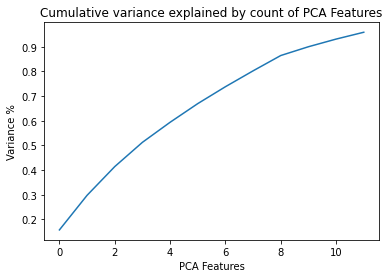

In [103]:
# dimensions reduced down to 12 in order to explain 95% of variance in our model.
plt.plot(range(0,len(pca.components_)), pca.explained_variance_ratio_.cumsum())
plt.xlabel("PCA Features")
plt.ylabel("Variance %")
plt.title("Cumulative variance explained by count of PCA Features")
plt.show()

<h2>The PCA shows that in order to explain 95% of the variability in the data we need 12 features (down from 127). This is however too many features for K-Means to work properly with Euclidian Distance, so for the sake of this exercise I will use 6 features as approx ~67% of the variability is explained, and is easier for K Means to work with. I show this more precisely below. </h2>

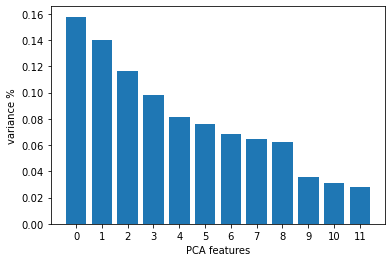

In [104]:
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show()

In [105]:
#variability explained by PCA
pca.explained_variance_ratio_[0:6].sum()

0.6695435661619364

<h2>Using 6 features makes it possible to find the knee to be used for the K-Means algorithm</h2>
This was done after testing all ranges 1 through 12 to see the effect. I choose not to keep all of this testing here to clutter the notebook. 

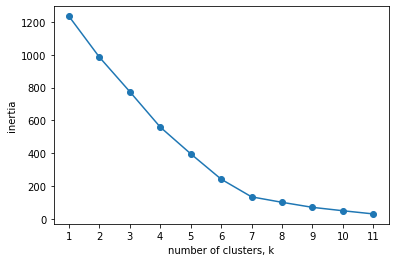

In [106]:
# add dataset to X variable
X = pd.DataFrame(kmeans_dataset)

# range of Ks to be iterated through
ks = range(1, len(pca.components_))

# list to keep sum of squared distances of samples to their closest cluster center for each iteration
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(init="k-means++", n_clusters=k)
    
    # Using 6 features to train the model
    model.fit(X.iloc[:,:6])

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

<h2>Retraining model using 7 Ks as this seems appropriate</h2>

In [107]:
# assigning Ks to use
k = 7

# add dataframe to X
X = pd.DataFrame(kmeans_dataset).iloc[:,:6]

# Create a KMeans instance with k clusters and fit model
model = KMeans(init="k-means++", n_clusters=k).fit(X)

# Using 6 features to train the model
model.fit(X.iloc[:,:6])

KMeans(n_clusters=7)

In [108]:
# add cluster labels back to master_df
master_df.insert(0, "Cluster Labels", model.labels_)
master_df

,Cluster Labels,Borough,Population,Square KM,Borough ID,lat,lng
0,1,Alna,49801.0,137.0,12,59.932417,10.835276
1,4,Bjerke,33422.0,77.0,9,59.940668,10.808725
2,2,Frogner,59269.0,83.0,5,59.922224,10.706649
3,6,Gamle Oslo,58671.0,75.0,1,59.907349,10.773927
4,1,Grorud,27707.0,82.0,10,59.961424,10.880549
5,0,Grünerløkka,62423.0,48.0,2,59.923856,10.757889
6,4,Nordre Aker,52327.0,136.0,8,59.953638,10.756412
7,3,Nordstrand,52459.0,169.0,14,59.864561,10.786143
8,4,Sagene,45089.0,31.0,3,59.936887,10.755306
9,4,St. Hanshaugen,38945.0,36.0,4,59.927950,10.738958


<h2>Result dataset containing all features with the cluster label. Boroughs will be added later</h2>

In [109]:
# add cluster labels to df_group 
df_group.insert(0, "Cluster Labels", model.labels_)
df_group

,Cluster Labels,Advertising Agency,Amphitheater,Art Museum,Arts & Crafts,Arts & Entertainment,Asian,Athletics & Sports,BBQ,Bakery,...,Tapas,Thai,Theme Park,Theme Restaurant,Track,Trail,Train Station,Wine Bar,Wine Shop,Yoga Studio
0,1,0.00,0.00,0.00,0.02,0.00,0.02,0.02,0.00,0.02,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00
1,4,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.04,...,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00
2,2,0.00,0.00,0.02,0.00,0.00,0.02,0.00,0.00,0.06,...,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.02
3,6,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,...,0.00,0.02,0.00,0.02,0.00,0.00,0.00,0.02,0.00,0.00
4,1,0.00,0.00,0.00,0.02,0.02,0.02,0.02,0.00,0.02,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00
5,0,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.04,0.04,...,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.00
6,4,0.02,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.10,...,0.00,0.02,0.02,0.00,0.00,0.00,0.00,0.00,0.06,0.00
7,3,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.02,...,0.00,0.00,0.00,0.02,0.02,0.00,0.00,0.00,0.00,0.00
8,4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,...,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00
9,4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,...,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00


<h2>Here I wanted to take a look at top 10 features that is within each cluster. The tables are re-sorted to correspond to the cluster we are looking at. These frequencies will be added as tooltips later to the map.<br><br>
Heatmap for Cluster 0 - sorted by itself descending</h2>

In [110]:
import seaborn as sns

#create a visual map to get some sense of what the clusters consist of
temp = df_group.groupby(by="Cluster Labels").sum().T

#group by clusters and sort descending
temp = temp.sort_values(0 , ascending=False).head(10)

#create seaborn heatmap
cm = sns.light_palette("green", as_cmap=True)

# set style
s = temp.style.background_gradient(cmap=cm)
s

Cluster Labels,0,1,2,3,4,5,6
Coffee Shop,0.080000,0.040000,0.060000,0.120000,0.320000,0.020000,0.120000
Bar,0.080000,0.000000,0.020000,0.100000,0.160000,0.000000,0.140000
Park,0.080000,0.020000,0.060000,0.160000,0.220000,0.020000,0.080000
Café,0.060000,0.180000,0.140000,0.120000,0.200000,0.060000,0.060000
Burgers,0.040000,0.040000,0.060000,0.000000,0.020000,0.020000,0.000000
Brewery,0.040000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000
Tapas,0.040000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000
French,0.040000,0.000000,0.040000,0.000000,0.040000,0.020000,0.000000
Cocktail,0.040000,0.000000,0.000000,0.000000,0.120000,0.000000,0.000000
Italian,0.040000,0.000000,0.100000,0.020000,0.040000,0.000000,0.020000


<h2>Heatmap for Cluster 1 - sorted by itself descending</h2>

In [111]:
#create a visual map to get some sense of what the clusters consist of
temp = df_group.groupby(by="Cluster Labels").sum().T

#group by clusters and sort descending
temp = temp.sort_values(1 , ascending=False).head(10)

#create seaborn heatmap
cm = sns.light_palette("green", as_cmap=True)

# set style
s = temp.style.background_gradient(cmap=cm)
s

Cluster Labels,0,1,2,3,4,5,6
Grocery Store,0.000000,0.440000,0.040000,0.200000,0.120000,0.040000,0.020000
Hotel,0.020000,0.220000,0.180000,0.020000,0.080000,0.100000,0.040000
Café,0.060000,0.180000,0.140000,0.120000,0.200000,0.060000,0.060000
Gym / Fitness,0.000000,0.180000,0.180000,0.100000,0.220000,0.040000,0.020000
Supermarket,0.000000,0.120000,0.080000,0.080000,0.020000,0.040000,0.000000
Furniture / Home,0.000000,0.100000,0.000000,0.020000,0.000000,0.000000,0.000000
Pizza,0.020000,0.100000,0.020000,0.020000,0.180000,0.000000,0.000000
Lodge,0.000000,0.100000,0.000000,0.160000,0.020000,0.000000,0.000000
Electronics,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000
Sporting Goods,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000


<h2>Heatmap for Cluster 2 - sorted by itself descending</h2>

In [112]:
#create a visual map to get some sense of what the clusters consist of
temp = df_group.groupby(by="Cluster Labels").sum().T

#group by clusters and sort descending
temp = temp.sort_values(2 , ascending=False).head(10)

#create seaborn heatmap
cm = sns.light_palette("green", as_cmap=True)

# set style
s = temp.style.background_gradient(cmap=cm)
s

Cluster Labels,0,1,2,3,4,5,6
Gym / Fitness,0.000000,0.180000,0.180000,0.100000,0.220000,0.040000,0.020000
Hotel,0.020000,0.220000,0.180000,0.020000,0.080000,0.100000,0.040000
Café,0.060000,0.180000,0.140000,0.120000,0.200000,0.060000,0.060000
Italian,0.040000,0.000000,0.100000,0.020000,0.040000,0.000000,0.020000
Bakery,0.040000,0.060000,0.100000,0.080000,0.280000,0.040000,0.000000
Wine Shop,0.000000,0.060000,0.080000,0.020000,0.140000,0.020000,0.000000
Supermarket,0.000000,0.120000,0.080000,0.080000,0.020000,0.040000,0.000000
Park,0.080000,0.020000,0.060000,0.160000,0.220000,0.020000,0.080000
History Museum,0.000000,0.000000,0.060000,0.020000,0.020000,0.000000,0.000000
Coffee Shop,0.080000,0.040000,0.060000,0.120000,0.320000,0.020000,0.120000


<h2>Heatmap for Cluster 3 - sorted by itself descending</h2>

In [113]:
#create a visual map to get some sense of what the clusters consist of
temp = df_group.groupby(by="Cluster Labels").sum().T

#group by clusters and sort descending
temp = temp.sort_values(3 , ascending=False).head(10)

#create seaborn heatmap
cm = sns.light_palette("green", as_cmap=True)

# set style
s = temp.style.background_gradient(cmap=cm)
s

Cluster Labels,0,1,2,3,4,5,6
Beach,0.000000,0.000000,0.060000,0.300000,0.000000,0.020000,0.000000
Grocery Store,0.000000,0.440000,0.040000,0.200000,0.120000,0.040000,0.020000
Sushi,0.000000,0.060000,0.040000,0.160000,0.140000,0.020000,0.040000
Lodge,0.000000,0.100000,0.000000,0.160000,0.020000,0.000000,0.000000
Park,0.080000,0.020000,0.060000,0.160000,0.220000,0.020000,0.080000
Asian,0.020000,0.060000,0.020000,0.120000,0.020000,0.000000,0.040000
Coffee Shop,0.080000,0.040000,0.060000,0.120000,0.320000,0.020000,0.120000
Café,0.060000,0.180000,0.140000,0.120000,0.200000,0.060000,0.060000
Gym / Fitness,0.000000,0.180000,0.180000,0.100000,0.220000,0.040000,0.020000
Bar,0.080000,0.000000,0.020000,0.100000,0.160000,0.000000,0.140000


<h2>Heatmap for Cluster 4 - sorted by itself descending</h2>

In [114]:
#create a visual map to get some sense of what the clusters consist of
temp = df_group.groupby(by="Cluster Labels").sum().T

#group by clusters and sort descending
temp = temp.sort_values(4 , ascending=False).head(10)

#create seaborn heatmap
cm = sns.light_palette("green", as_cmap=True)

# set style
s = temp.style.background_gradient(cmap=cm)
s

Cluster Labels,0,1,2,3,4,5,6
Coffee Shop,0.080000,0.040000,0.060000,0.120000,0.320000,0.020000,0.120000
Bakery,0.040000,0.060000,0.100000,0.080000,0.280000,0.040000,0.000000
Gym / Fitness,0.000000,0.180000,0.180000,0.100000,0.220000,0.040000,0.020000
Park,0.080000,0.020000,0.060000,0.160000,0.220000,0.020000,0.080000
Café,0.060000,0.180000,0.140000,0.120000,0.200000,0.060000,0.060000
Restaurant,0.000000,0.020000,0.040000,0.080000,0.180000,0.040000,0.040000
Gym,0.000000,0.040000,0.000000,0.000000,0.180000,0.000000,0.000000
Pizza,0.020000,0.100000,0.020000,0.020000,0.180000,0.000000,0.000000
Bar,0.080000,0.000000,0.020000,0.100000,0.160000,0.000000,0.140000
Sushi,0.000000,0.060000,0.040000,0.160000,0.140000,0.020000,0.040000


<h2>Heatmap for Cluster 5 - sorted by itself descending</h2>

In [115]:
#create a visual map to get some sense of what the clusters consist of
temp = df_group.groupby(by="Cluster Labels").sum().T

#group by clusters and sort descending
temp = temp.sort_values(5 , ascending=False).head(10)

#create seaborn heatmap
cm = sns.light_palette("green", as_cmap=True)

# set style
s = temp.style.background_gradient(cmap=cm)
s

Cluster Labels,0,1,2,3,4,5,6
Hotel,0.020000,0.220000,0.180000,0.020000,0.080000,0.100000,0.040000
Ski Area,0.000000,0.040000,0.000000,0.000000,0.000000,0.080000,0.000000
Café,0.060000,0.180000,0.140000,0.120000,0.200000,0.060000,0.060000
Grocery Store,0.000000,0.440000,0.040000,0.200000,0.120000,0.040000,0.020000
Restaurant,0.000000,0.020000,0.040000,0.080000,0.180000,0.040000,0.040000
Golf Course,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000
Athletics & Sports,0.000000,0.060000,0.000000,0.020000,0.020000,0.040000,0.000000
Trail,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000
Bakery,0.040000,0.060000,0.100000,0.080000,0.280000,0.040000,0.000000
Supermarket,0.000000,0.120000,0.080000,0.080000,0.020000,0.040000,0.000000


<h2>Heatmap for Cluster 6 - sorted by itself descending</h2>

In [116]:
#create a visual map to get some sense of what the clusters consist of
temp = df_group.groupby(by="Cluster Labels").sum().T

#group by clusters and sort descending
temp = temp.sort_values(6 , ascending=False).head(10)

#create seaborn heatmap
cm = sns.light_palette("green", as_cmap=True)

# set style
s = temp.style.background_gradient(cmap=cm)
s

Cluster Labels,0,1,2,3,4,5,6
Bar,0.080000,0.000000,0.020000,0.100000,0.160000,0.000000,0.140000
Coffee Shop,0.080000,0.040000,0.060000,0.120000,0.320000,0.020000,0.120000
Park,0.080000,0.020000,0.060000,0.160000,0.220000,0.020000,0.080000
Indian,0.040000,0.000000,0.040000,0.000000,0.120000,0.000000,0.060000
Café,0.060000,0.180000,0.140000,0.120000,0.200000,0.060000,0.060000
Asian,0.020000,0.060000,0.020000,0.120000,0.020000,0.000000,0.040000
Hotel,0.020000,0.220000,0.180000,0.020000,0.080000,0.100000,0.040000
Sushi,0.000000,0.060000,0.040000,0.160000,0.140000,0.020000,0.040000
Record Shop,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.040000
Restaurant,0.000000,0.020000,0.040000,0.080000,0.180000,0.040000,0.040000


<h2>Creating a string of venue frequencies to be used for each cluster.</h2>

In [117]:
# creating a list to be used as a dataframe after looping
df_categories = []

# creating a group by dataframe to get frequencies from 
tbl = df_group.groupby(by="Cluster Labels").mean().T

# looping through all the different clusters to get frequencies
for i in range(0, k):

    # group by clusters and sort descending
    temp = tbl.sort_values(i, ascending=False).head(10)
    
    # create a dictionary with each result to be appended into a dataframe
    data = {
        temp.columns[0]: round( temp.iloc[:10, i ], 2) * 100
    }

    # appending data
    df_categories.append(data)

# creating the dataframe
df_categories = pd.DataFrame(df_categories)

# setting Cluster Labels column to the cluster IDs
df_categories["Cluster Labels"] = df_categories.index

# renaming columns
df_categories.columns = ["Category Freq", "Cluster Labels"]

df_categories


,Category Freq,Cluster Labels
0,Coffee Shop 8.0 Bar 8.0 Park ...,0
1,Grocery Store 15.0 Hotel ...,1
2,Gym / Fitness 9.0 Hotel 9.0 Ca...,2
3,Beach 10.0 Grocery Store 7.0 Su...,3
4,Coffee Shop 8.0 Bakery 7.0 Gym ...,4
5,Hotel 10.0 Ski Area ...,5
6,Bar 14.0 Coffee Shop 12.0 Park ...,6


<h1> Plotting the clusters with Folium </h1>

In [118]:
#joining Categories and their frequencies back to the main dataframe
df_map = master_df.join(df_group, rsuffix="_")

#dropping duplicate column after join
df_map = df_categories.join(master_df.set_index("Cluster Labels"))
df_map.reset_index(inplace=True, drop=True)
df_map.head(15)

,Category Freq,Cluster Labels,Borough,Population,Square KM,Borough ID,lat,lng
0,Coffee Shop 8.0 Bar 8.0 Park ...,0,Grünerløkka,62423.0,48.0,2,59.923856,10.757889
1,Grocery Store 15.0 Hotel ...,1,Alna,49801.0,137.0,12,59.932417,10.835276
2,Grocery Store 15.0 Hotel ...,1,Grorud,27707.0,82.0,10,59.961424,10.880549
3,Grocery Store 15.0 Hotel ...,1,Stovner,33316.0,82.0,11,59.962140,10.922823
4,Gym / Fitness 9.0 Hotel 9.0 Ca...,2,Frogner,59269.0,83.0,5,59.922224,10.706649
5,Gym / Fitness 9.0 Hotel 9.0 Ca...,2,Ullern,34569.0,94.0,6,59.925567,10.655798
6,Beach 10.0 Grocery Store 7.0 Su...,3,Nordstrand,52459.0,169.0,14,59.864561,10.786143
7,Beach 10.0 Grocery Store 7.0 Su...,3,Søndre Nordstrand,39066.0,184.0,15,59.835944,10.798496
8,Beach 10.0 Grocery Store 7.0 Su...,3,Østensjø,50806.0,122.0,13,59.887563,10.832748
9,Coffee Shop 8.0 Bakery 7.0 Gym ...,4,Bjerke,33422.0,77.0,9,59.940668,10.808725


In [119]:
# adding pct of total population to show differences between buroughs
df_map["Density pct of total"] = round( ( ( df_map["Population"] / df_map["Population"].sum() ) * 100 ), 1 )
df_map

,Category Freq,Cluster Labels,Borough,Population,Square KM,Borough ID,lat,lng,Density pct of total
0,Coffee Shop 8.0 Bar 8.0 Park ...,0,Grünerløkka,62423.0,48.0,2,59.923856,10.757889,9.1
1,Grocery Store 15.0 Hotel ...,1,Alna,49801.0,137.0,12,59.932417,10.835276,7.2
2,Grocery Store 15.0 Hotel ...,1,Grorud,27707.0,82.0,10,59.961424,10.880549,4.0
3,Grocery Store 15.0 Hotel ...,1,Stovner,33316.0,82.0,11,59.962140,10.922823,4.8
4,Gym / Fitness 9.0 Hotel 9.0 Ca...,2,Frogner,59269.0,83.0,5,59.922224,10.706649,8.6
5,Gym / Fitness 9.0 Hotel 9.0 Ca...,2,Ullern,34569.0,94.0,6,59.925567,10.655798,5.0
6,Beach 10.0 Grocery Store 7.0 Su...,3,Nordstrand,52459.0,169.0,14,59.864561,10.786143,7.6
7,Beach 10.0 Grocery Store 7.0 Su...,3,Søndre Nordstrand,39066.0,184.0,15,59.835944,10.798496,5.7
8,Beach 10.0 Grocery Store 7.0 Su...,3,Østensjø,50806.0,122.0,13,59.887563,10.832748,7.4
9,Coffee Shop 8.0 Bakery 7.0 Gym ...,4,Bjerke,33422.0,77.0,9,59.940668,10.808725,4.9


In [120]:
#importing Folium
#! pip install folium==0.5.0  
import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

<h2>Creating Folium Map</h2>

In [121]:
# create map using latitude and longitude values as a reference
m = folium.Map([df_map["lat"].mean(),df_map["lng"].mean()],zoom_start=12)

# add markers to the map
markers_colors = []
radius_circles = 10

# set color scheme for the clusters
x_col = np.arange(k)
ys = [i + x_col + (i*x_col)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lng, borough, cluster_labels, cat_freq, pop, sqr, pct in zip(df_map['lat'], df_map['lng'], df_map['Borough'], df_map["Cluster Labels"], df_map["Category Freq"], df_map["Population"], df_map["Square KM"], df_map["Density pct of total"]):

    # poplation number per square KM
    density = round( ( pop / sqr  ), 0 ) 
    
    # add the grouped common venues as label
    label = folium.Popup(f"Borough: {str(borough)}, Population Density per KM: {density} ({pct}%), Categories(%): {cat_freq} ", parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=radius_circles,
        color=rainbow[cluster_labels-1],
        fill_color=rainbow[cluster_labels-1],
        popup=label,
        fill=True,
        fill_opacity=0.7).add_to(m)

    folium.Circle(
        [lat, lng],
        radius=pct * 100,
        color=rainbow[cluster_labels-1],
        fill_color=rainbow[cluster_labels-1]
    ).add_to(m)

<h2>The map beneath shows Oslo with all 15 boroughs colored by 7 cluster identities. The size of the rings represents population density as percentage of total within Oslo. For information about the buroughs please click the clusters.</h2> <br>
Example: "Grünerløkka"  has the most spread activity offers with bars as the top with 8.0% and different places to eat. It also has the largest population density of 9.1% - so this might be a place to live for someone who enjoys people, and a multitude of different offers. <br><br>
"Nordstrand" is close to beaches with lodges and lower population density than Grünerløkka - a quiter more serene place? <br><br>
"Gamle Oslo" has a high population density, but lower than Grünerløkka and has a very high density of bars with 14%! This could be a great place to live for someone who likes to party. 

In [122]:
m

In [123]:
#Data used in the map
df_map

,Category Freq,Cluster Labels,Borough,Population,Square KM,Borough ID,lat,lng,Density pct of total
0,Coffee Shop 8.0 Bar 8.0 Park ...,0,Grünerløkka,62423.0,48.0,2,59.923856,10.757889,9.1
1,Grocery Store 15.0 Hotel ...,1,Alna,49801.0,137.0,12,59.932417,10.835276,7.2
2,Grocery Store 15.0 Hotel ...,1,Grorud,27707.0,82.0,10,59.961424,10.880549,4.0
3,Grocery Store 15.0 Hotel ...,1,Stovner,33316.0,82.0,11,59.962140,10.922823,4.8
4,Gym / Fitness 9.0 Hotel 9.0 Ca...,2,Frogner,59269.0,83.0,5,59.922224,10.706649,8.6
5,Gym / Fitness 9.0 Hotel 9.0 Ca...,2,Ullern,34569.0,94.0,6,59.925567,10.655798,5.0
6,Beach 10.0 Grocery Store 7.0 Su...,3,Nordstrand,52459.0,169.0,14,59.864561,10.786143,7.6
7,Beach 10.0 Grocery Store 7.0 Su...,3,Søndre Nordstrand,39066.0,184.0,15,59.835944,10.798496,5.7
8,Beach 10.0 Grocery Store 7.0 Su...,3,Østensjø,50806.0,122.0,13,59.887563,10.832748,7.4
9,Coffee Shop 8.0 Bakery 7.0 Gym ...,4,Bjerke,33422.0,77.0,9,59.940668,10.808725,4.9
